# k-means clustering stocks

In this project, I am looking for price data for Yahoo Finance API S&P 100 shares in January 1, 2020 to January 1, 2021. Next, I am calculating your historical returns and volatility and then proceed to use the K-Means clustering algorithm to divide stocks into separate groups based on those returns and volatilities.

## Importing libraries

In [1]:
%matplotlib inline
import numpy as np
from numpy import percentile
import pandas as pd
import pandas_datareader as dr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import datetime
from sklearn import metrics
from sklearn.cluster import KMeans
import warnings
from math import sqrt
from scipy.cluster.vq import kmeans,vq
warnings.filterwarnings('ignore')

## Configure Matplotlib

In [2]:
matplotlib.style.use('ggplot')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

## Load data

In [3]:
#scraping wikipedia to fetch S&P 100 stock list
data_table = pd.read_html("https://en.wikipedia.org/wiki/S%26P_100")

df = data_table[2]['Symbol']

print("\nTotal number of companies are:" + str(len(df)))

tickers = df.tolist()
prices_list = []
for ticker in tickers:
    try:
        prices = dr.DataReader(ticker, 'yahoo', '01/01/2020', '01/01/2021')
        prices = prices[['Close']]
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    df_prices = pd.concat(prices_list,axis=1)
df_prices.sort_index(inplace=True)


Total number of companies are:101


## Data description

There are 101 columns in the data set, each column represents a company. The data period is from January 1, 2020 until January 1, 2021. The value of the stock price used in the project is that of closing.

## Explore data

In [4]:
df_prices.shape

(253, 100)

In [5]:
# data types of columns
df_prices.dtypes

AAPL    float64
ABBV    float64
ABT     float64
ACN     float64
ADBE    float64
         ...   
VZ      float64
WBA     float64
WFC     float64
WMT     float64
XOM     float64
Length: 100, dtype: object

In [6]:
# Check missing value
df_prices.isnull().sum()

AAPL    0
ABBV    0
ABT     0
ACN     0
ADBE    0
       ..
VZ      0
WBA     0
WFC     0
WMT     0
XOM     0
Length: 100, dtype: int64

## Calculate the monthly returns for the sp100 stocks

In [7]:
returns = df_prices.pct_change()
compounded = ((np.prod(returns+1)-1)*100).round(2)

## Calculate the average monthly return

In [8]:
M = 1*12
average_monthly_returns = (compounded/M)

## Calculate their volatility

In [9]:
volatility = returns.std()

## Concatenate the arrays

In [10]:
returns_volatility = np.column_stack((average_monthly_returns, volatility))

## Create Model

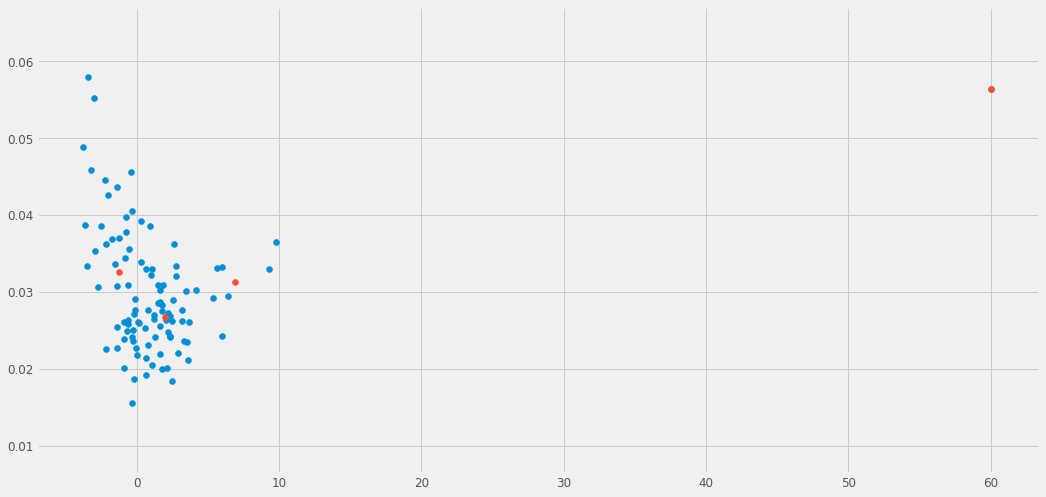

In [11]:
km_res = KMeans(n_clusters=4).fit(returns_volatility)
km_res.cluster_centers_
 
clusters = km_res.cluster_centers_
plt.figure(figsize=(16,8)) 
plt.scatter(average_monthly_returns, volatility)
plt.scatter(clusters[:,0], clusters[:,1])
 
a_m_returns_volatility= np.nan_to_num(returns_volatility)

labels = km_res.labels_
returns_volatility_clusters = np.column_stack((average_monthly_returns, volatility, labels))

## Associate each Stock to corresponding cluster

In [12]:
returns_volatility_clusters = np.column_stack((average_monthly_returns, volatility, labels))

## Convert into dataframe

In [13]:
df_returns_volatility_clusters = pd.DataFrame(returns_volatility_clusters)
print(df_returns_volatility_clusters.head())

          0         1    2
0  6.392500  0.029423  3.0
1  1.637500  0.021920  0.0
2  2.160000  0.024714  0.0
3  2.025000  0.026349  0.0
4  4.128333  0.030232  0.0


In [14]:
df_returns_volatility_clusters.columns = ['average_monthly_returns', 'volatility_monthly', 'cluster_label']
df_returns_volatility_clusters.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df_returns_volatility_clusters['cluster_label'] = df_returns_volatility_clusters['cluster_label'].astype(int)
df_returns_volatility_clusters.dtypes

average_monthly_returns    float64
volatility_monthly         float64
cluster_label                int32
dtype: object

## Plot results

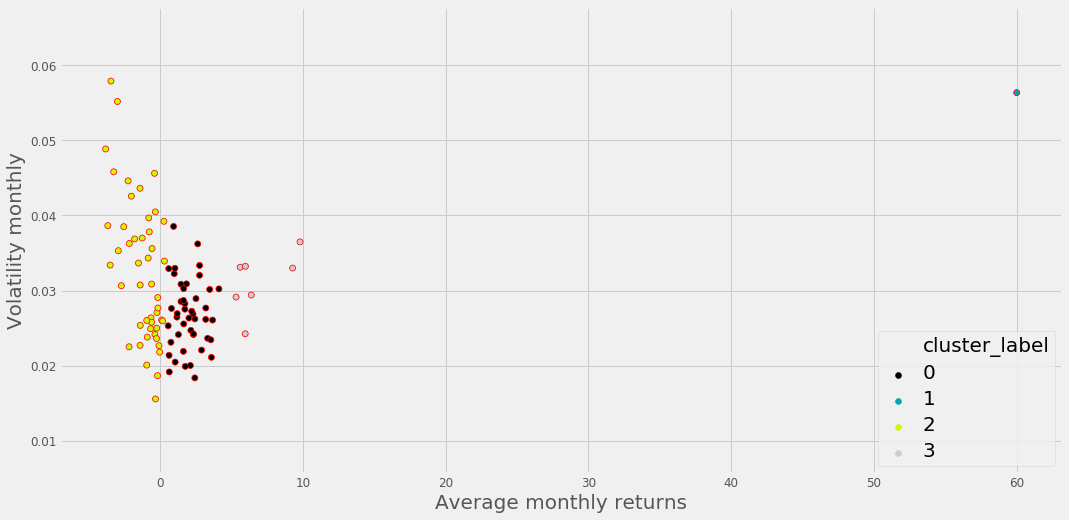

In [15]:
plt.figure(figsize=(16,8)) 
ax = sns.scatterplot(x="average_monthly_returns", y="volatility_monthly", edgecolor='r', hue="cluster_label",
                     data=df_returns_volatility_clusters, palette = "nipy_spectral")
plt.xlabel('Average monthly returns', size=20)
plt.ylabel('Volatility monthly', size=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='20')
plt.savefig('scatterplot', dpi=300) 

## Add Index (Symbol)

In [16]:
df_average_monthly_returns = pd.DataFrame(average_monthly_returns)
df_average_monthly_returns.reset_index(level=0, inplace=True)
df_average_monthly_returns.columns = ['index', 'average_monthly_returns']
df_final = pd.merge(df_average_monthly_returns, df_returns_volatility_clusters)
print(df_final.head())

  index  average_monthly_returns  volatility_monthly  cluster_label
0  AAPL                 6.392500            0.029423              3
1  ABBV                 1.637500            0.021920              0
2   ABT                 2.160000            0.024714              0
3   ACN                 2.025000            0.026349              0
4  ADBE                 4.128333            0.030232              0


## Removing outliers

In [17]:
# Get the row label of the maximum value 
print(compounded.idxmax())
# Delete TSLA
df_final = df_final[df_final['index'] != 'TSLA']
print(df_final.head())

TSLA
  index  average_monthly_returns  volatility_monthly  cluster_label
0  AAPL                 6.392500            0.029423              3
1  ABBV                 1.637500            0.021920              0
2   ABT                 2.160000            0.024714              0
3   ACN                 2.025000            0.026349              0
4  ADBE                 4.128333            0.030232              0


## Plot results without outliers

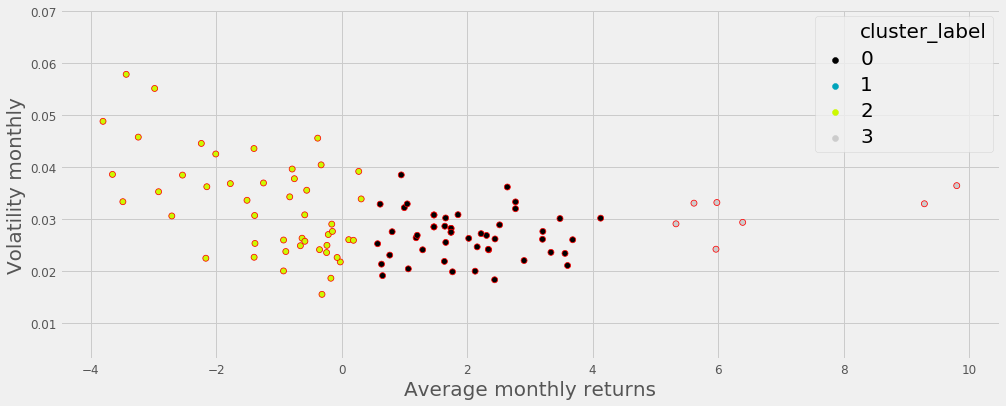

In [18]:
ax = sns.scatterplot(x="average_monthly_returns", y="volatility_monthly", edgecolor='r', hue="cluster_label",
                     data=df_final, palette = "nipy_spectral")
plt.xlabel('Average monthly returns', size=20)
plt.ylabel('Volatility monthly', size=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='20')
plt.savefig('scatterplot', dpi=300) 

## Elbow Method

Text(0, 0.5, 'Inertia')

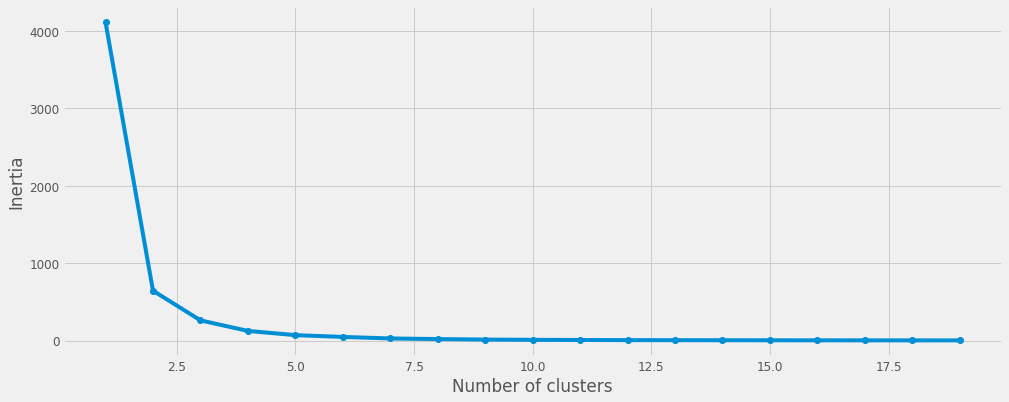

In [19]:
SSE = []
for cluster in range(1,20):
    km_res = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    km_res.fit(returns_volatility)
    SSE.append(km_res.inertia_)
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

## Adjust model for 3 clusters

In [20]:
del df_prices['TSLA']
returns = df_prices.pct_change()
compounded = ((np.prod(returns+1)-1)*100).round(2)

M = 1*12
average_monthly_returns = (compounded/M)

volatility = returns.std()

returns_volatility = np.column_stack((average_monthly_returns, volatility))

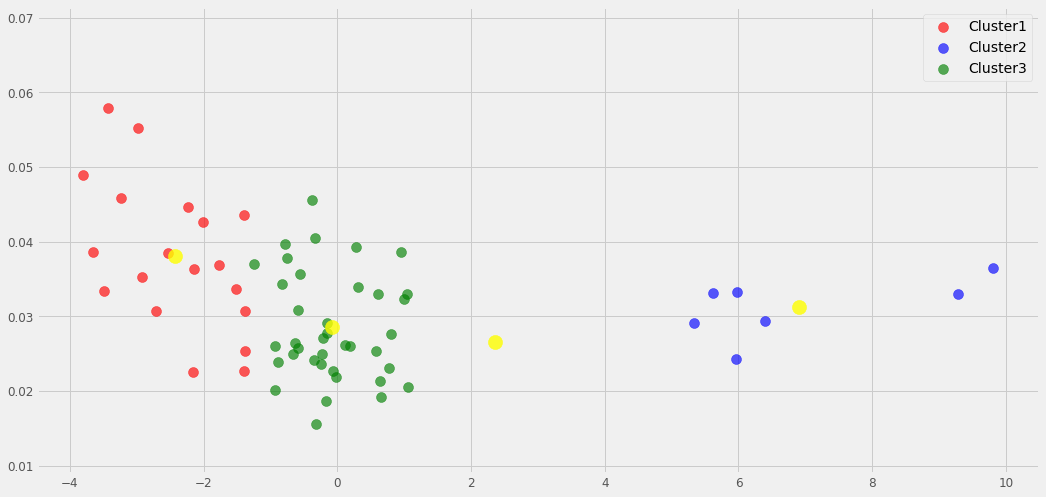

In [21]:
km_res = KMeans(n_clusters=4).fit(returns_volatility)
km_res.cluster_centers_
clusters = km_res.cluster_centers_
idx,_ = vq(returns_volatility,clusters)

plt.figure(figsize=(16,8))
plt.scatter(returns_volatility[idx==0,0],returns_volatility[idx==0,1],s=100,c='red',label='Cluster1',alpha=0.65)
plt.scatter(returns_volatility[idx==1,0],returns_volatility[idx==1,1],s=100,c='blue',label='Cluster2',alpha=0.65)
plt.scatter(returns_volatility[idx==2,0],returns_volatility[idx==2,1],s=100,c='green',label='Cluster3',alpha=0.65)
plt.scatter(clusters[:,0],clusters[:,1],s=200, c='yellow', alpha = 0.8)
plt.legend()
plt.show()

## Quantity by clusters

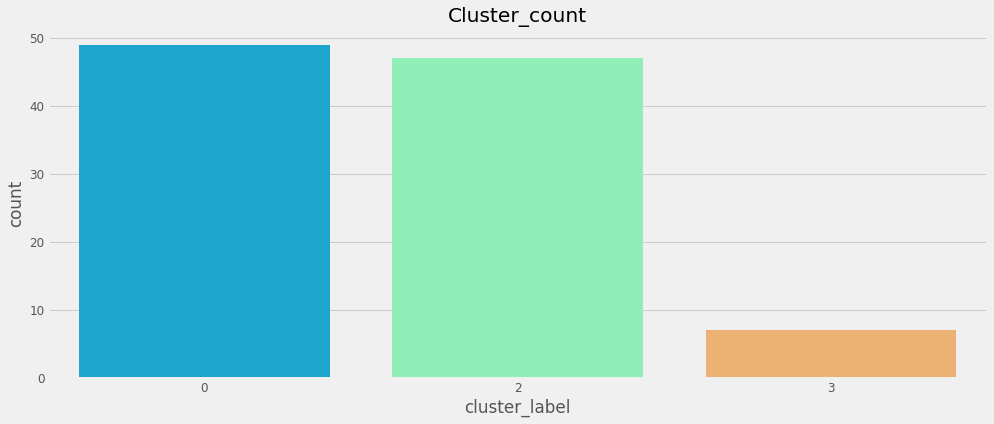

In [22]:
sns.countplot(x = 'cluster_label', data = df_final, palette = 'rainbow')
plt.title('Cluster_count')
plt.show()

## Return by cluster

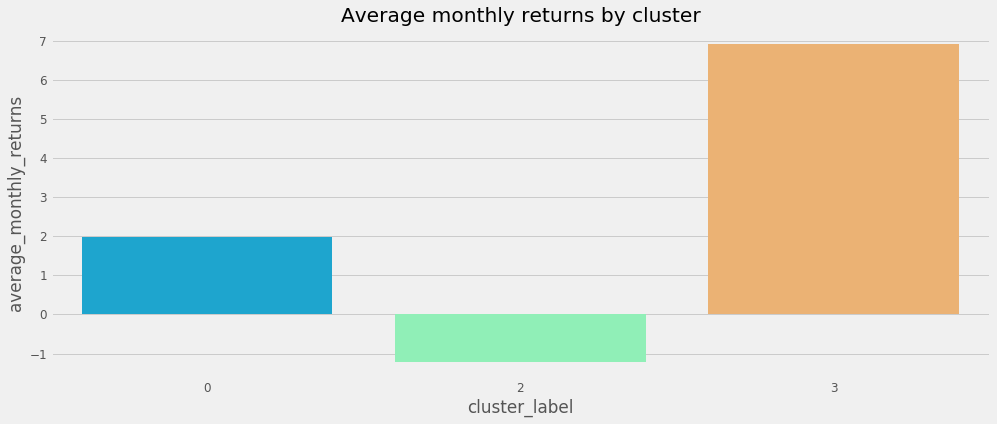

In [23]:
df_descriptive_stats = df_final.iloc[:, 1:4]
df_groupby_cluster = df_descriptive_stats.groupby(['cluster_label'], as_index=False).mean()

sns.barplot(x = 'cluster_label', y = 'average_monthly_returns', data = df_groupby_cluster, palette = 'rainbow', edgecolor='none')
plt.title('Average monthly returns by cluster')
plt.show()